# What is RFM Analysis?
RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.

# The three components of RFM analysis:
- **Recency(R)**: Recency measures how recently a customer made a purchase. Recency matters because it serves as an engagement indicator, showing that customers who purchased recently are more likely to engage with your marketing campaigns. It also acts as a retention predictor, as recent buyers are more likely to return. Additionally, high recency scores allow you to target customers with personalized messages and offers, maximizing the chances of repeat purchases.
- **Frequency(F)**: Frequency measures how often a customer makes a purchase within a specified time period. It helps identify your loyal repeat buyers. Frequent buyers provide consistent revenue streams, making them valuable to your business. Moreover, customers with high frequency are more likely to respond positively to upsell and cross-sell opportunities, further boosting your revenue.
- **Monetary Value(M)**: Monetary Value measures the total amount of money a customer has spent within a specified time period. It helps identify high-value customers who contribute significantly to your revenue. 

# RFM Analysis
This notebook performs Recency, Frequency, Monetary (RFM) segmentation on retail transaction data and derives actionable insights for business decisions. We assign a RFM score to each person. The RFM score is a numerical score that helps us to recognize all types of customers, from the best to the worst.

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta


In [2]:
# Load dataset
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
# Keep only valid transactions
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


In [3]:
# Define snapshot date for recency (one day after last invoice)
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
snapshot_date

Timestamp('2011-12-11 17:19:00')

In [4]:
# Aggregate RFM metrics by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
})
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,327,1,77183.60
12347.0,41,7,4310.00
12348.0,77,4,1797.24
12349.0,20,1,1757.55
12350.0,312,1,334.40


In [5]:
# --- Scoring with automatic binning and numeric codes ---
# Recency: more recent → higher score
r_cat = pd.qcut(rfm['Recency'], q=4, duplicates='drop')
rfm['R_score'] = r_cat.cat.codes + 1            # codes go 0..n_bins-1, so +1 gives 1..n_bins
rfm['R_score'] = rfm['R_score'].max() + 1 - rfm['R_score']
#    ↑ invert so that smallest Recency (most recent) => highest score

# Frequency: higher → higher score
f_cat = pd.qcut(rfm['Frequency'], q=4, duplicates='drop')
rfm['F_score'] = f_cat.cat.codes + 1

# Monetary: higher → higher score
m_cat = pd.qcut(rfm['Monetary'], q=4, duplicates='drop')
rfm['M_score'] = m_cat.cat.codes + 1

# Combine
rfm['RFM_Segment'] = (
    rfm['R_score'].astype(str)
    + rfm['F_score'].astype(str)
    + rfm['M_score'].astype(str)
)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,327,1,77183.60,1,1,4,114,6
12347.0,41,7,4310.00,3,3,4,334,10
12348.0,77,4,1797.24,2,2,4,224,8
12349.0,20,1,1757.55,4,1,4,414,9
12350.0,312,1,334.40,1,1,2,112,4


## Segment Definitions
- **Champions**: RFM_Score ≥ 9 – Most valuable and loyal customers.
- **Loyal Customers**: 6 ≤ RFM_Score < 9 – Frequent buyers with solid revenue.
- **Potential Loyalists**: 4 ≤ RFM_Score < 6 – Good recent engagement but lower spend.
- **At Risk**: RFM_Score < 4 – Lapsed or low-value customers.


In [6]:
def assign_segment(row):
    if row['RFM_Score'] >= 9:
        return 'Champions'
    elif row['RFM_Score'] >= 6:
        return 'Loyal Customers'
    elif row['RFM_Score'] >= 4:
        return 'Potential Loyalists'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)
rfm['Segment'].value_counts()

Loyal Customers        1464
Champions              1217
Potential Loyalists    1152
At Risk                 506
Name: Segment, dtype: int64

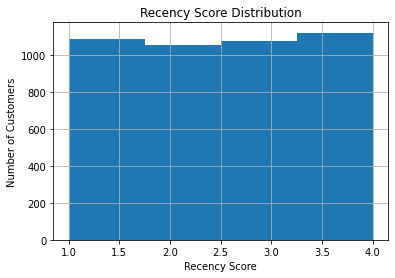

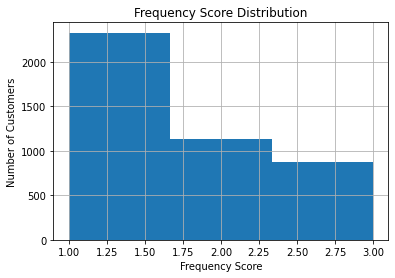

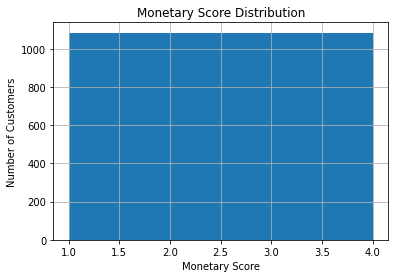

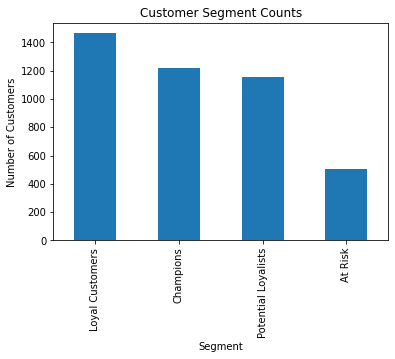

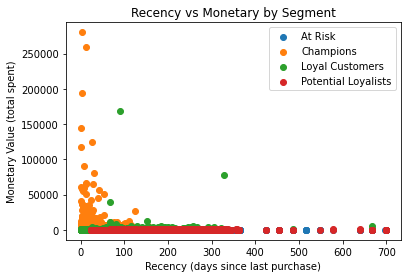

In [7]:
import matplotlib.pyplot as plt

# Assuming `rfm` DataFrame is already defined from the previous RFM computation

# 1. Distribution of R, F, M scores
plt.figure()
rfm['R_score'].hist(bins=rfm['R_score'].nunique())
plt.title('Recency Score Distribution')
plt.xlabel('Recency Score')
plt.ylabel('Number of Customers')
plt.show()

plt.figure()
rfm['F_score'].hist(bins=rfm['F_score'].nunique())
plt.title('Frequency Score Distribution')
plt.xlabel('Frequency Score')
plt.ylabel('Number of Customers')
plt.show()

plt.figure()
rfm['M_score'].hist(bins=rfm['M_score'].nunique())
plt.title('Monetary Score Distribution')
plt.xlabel('Monetary Score')
plt.ylabel('Number of Customers')
plt.show()

# 2. Customer segment counts
plt.figure()
rfm['Segment'].value_counts().plot(kind='bar')
plt.title('Customer Segment Counts')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.show()

# 3. Recency vs Monetary scatter, colored by segment (default color cycle)
plt.figure()
for seg, group in rfm.groupby('Segment'):
    plt.scatter(group['Recency'], group['Monetary'], label=seg)
plt.legend()
plt.title('Recency vs Monetary by Segment')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Monetary Value (total spent)')
plt.show()


  # What Recency actually means (in our analysis):
  Recency = number of days since last purchase

So:

- Lower Recency → More recent purchase (better!)

- Higher Recency → Older purchase (worse)



# Interpretation of the graph:
- Left side (low Recency) = Customers who purchased recently

- Right side (high Recency) = Customers who haven’t purchased in a long time

- Top = High spenders, Bottom = Low spenders

| Quadrant     | Meaning                                | Action                               |
|--------------|----------------------------------------|--------------------------------------|
| Top-left     | Recent + High spend → Champions        | Keep them happy, offer VIP treatment |
| Bottom-left  | Recent + Low spend → New or potential   | Encourage loyalty, cross-sell        |
| Top-right    | Not recent + High spend → At Risk       | Win-back with special offers         |
| Bottom-right | Not recent + Low spend → Inactive/low value | Low priority, bulk promos        |


## Conclusions & Business Recommendations
- **Champions**: These top-tier customers should be rewarded with exclusive offers or early access to new products to maintain loyalty.
- **Loyal Customers**: Implement a tiered loyalty program and personalized cross-sell campaigns to encourage increased spend.
- **Potential Loyalists**: Offer targeted incentives (e.g., discount on next purchase) to boost their transaction frequency.
- **At Risk**: Launch win-back campaigns (e.g., survey with discount code) to re-engage these customers before they churn.
- **Overall**: Monitor RFM segment shifts over time to evaluate the effectiveness of marketing strategies and adjust thresholds as needed.